<a href="https://colab.research.google.com/github/ravi-gopalan/DAND_Data_Wrangling/blob/master/custom_entity_processing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Mounted at /gdrive
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py", line 2882, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-3-cd0a7580851e>", line 3, in <module>
    get_ipython().magic('cd /gdrive')
  File "/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py", line 2160, in magic
    return self.run_line_magic(magic_name, magic_arg_s)
  File "/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py", line 2081, in run_line_magic
    result = fn(*args,**kwargs)
  File "</usr/local/lib/python3.6/dist-packages/decorator.py:decorator-gen-91>", line 2, in cd
  File "/usr/local/lib/python3.6/dist-packages/IPython/core/magic.py", line 188, in <lambda>
    call = lambda f, *a, **k: f(*a, **k)
  File "/usr/local/lib/python3.6/dist-packages/IPython/core/magics/osm.py", line 288, in cd
    oldcwd = py3compat.getcwd()
OSError: [Errno 107] Transport end

OSError: ignored

In [141]:
cd '/gdrive/My Drive/abv_reviews'

/gdrive/My Drive/abv_reviews


In [3]:
!pip install spacymoji
from spacymoji import Emoji

     |████████████████████████████████| 51kB 4.9MB/s 
  Created wheel for emoji: filename=emoji-0.5.4-cp36-none-any.whl size=42175 sha256=25e513ed91c7e81ef7b75bb9fee1678d355b118a9b96424830bf8c928799c6df
  Stored in directory: /root/.cache/pip/wheels/2a/a9/0a/4f8e8cce8074232aba240caca3fade315bb49fac68808d1a9c
Successfully built emoji


In [4]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")
import re
import random
import srsly
import json
import spacy
from spacy.lang.en import English
from spacy.pipeline import EntityRuler
from spacy import displacy
from spacy.util import minibatch, compounding
from pandas.io.json import json_normalize
from spacy.gold import docs_to_json, biluo_tags_from_offsets, offsets_from_biluo_tags
import spacy.cli
spacy.cli.download("en_core_web_lg")
import en_core_web_lg

import itertools

✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_lg')


In [0]:
def cleanse_text(text):
  step1 = re.sub(r"(\{'LOWER':\s)",r"",str(text))
  step2 = re.sub(r"[\[{\'\,\"}\]]",r"",step1)
  return step2

def trim_entity_spans(data: list) -> list:
    """Removes leading and trailing white spaces from entity spans.

    Args:
        data (list): The data to be cleaned in spaCy JSON format.

    Returns:
        list: The cleaned data.
    """
    invalid_span_tokens = re.compile(r'\s')

    cleaned_data = []
    for text, annotations in data:
        entities = annotations['entities']

        print(text, annotations)
        valid_entities = []
        for start, end, label in entities:
          valid_start = start
          valid_end = end
          print(valid_start, valid_end, len(text))
          while valid_start < len(text) and invalid_span_tokens.match(text[valid_start]):
            valid_start += 1
          while valid_end > 1 and invalid_span_tokens.match(text[valid_end - 1]):
            valid_end -= 1
          valid_entities.append([valid_start, valid_end, label])
        cleaned_data.append([text, {'entities': valid_entities}])

    return cleaned_data

def dump_jsonl(data, output_path, append=False):
    """
    Write list of objects to a JSON lines file.
    """
    mode = 'a+' if append else 'w'
    with open(output_path, mode, encoding='utf-8') as f:
        for line in data:
            json_record = json.dumps(line, ensure_ascii=False)
            f.write(json_record + '\n')
    print('Wrote {} records to {}'.format(len(data), output_path))

def load_jsonl(input_path) -> list:
    """
    Read list of objects from a JSON lines file.
    """
    data = []
    with open(input_path, 'r', encoding='utf-8') as f:
        for line in f:
            data.append(json.loads(line.rstrip('\n|\r')))
    print('Loaded {} records from {}'.format(len(data), input_path))
    return data


def create_entity_pattern(ent_name, ent_label):
  pattern_list = []
  pattern_dict = {}
  id_str = ''
  for word in ent_name.lower().split():
    token_dict = {}
    token_dict['LOWER'] = word
    pattern_list.append(token_dict)
    id_str += '_' + word
  if ent_label[:2] == 'U_':
    pattern_dict['label'] = ent_label[2:]
  else:
    pattern_dict['label'] = ent_label  
  pattern_dict['pattern'] = pattern_list
  if id_str[0] == '_':
    id_str = id_str[1:]
  pattern_dict['id'] = id_str
  return pattern_dict

In [142]:
ls -l patt*

-rw------- 1 root root   2365 Dec 26 18:11 pattern_bread.jsonl
-rw------- 1 root root   4609 Dec 26 18:11 pattern_condiment.jsonl
-rw------- 1 root root   5397 Dec 26 18:11 pattern_fruit.jsonl
-rw------- 1 root root   3946 Dec 26 18:11 pattern_herb.jsonl
-rw------- 1 root root   1700 Dec 26 18:11 pattern_pastry.jsonl
-rw------- 1 root root 529064 Dec 26 14:49 patterns_2019_12_26.jsonl
-rw------- 1 root root 589611 Jan  8 14:35 patterns_2020_01_08.jsonl
-rw------- 1 root root 622157 Jan 10 05:04 patterns.jsonl
-rw------- 1 root root   6749 Dec 26 18:11 pattern_spice.jsonl
-rw------- 1 root root   9140 Dec 26 18:11 pattern_vegetable.jsonl


In [143]:
df_pattern = pd.read_json('patterns.jsonl',lines=True)
df_pattern['cleaned_pattern'] = df_pattern.pattern.apply(lambda x: cleanse_text(x))
df_pattern['label'] = 'U_' + df_pattern.label.astype(str)
df_pattern['tup_col'] = list(zip(df_pattern.cleaned_pattern, df_pattern.label))
df_pattern['merged'] = df_pattern.apply(lambda row: {row['cleaned_pattern']:row['label']}, axis=1)
df_pattern.head()
df_pattern.tail()

,label,pattern,id,cleaned_pattern,tup_col,merged
7005,U_vegetable,[{'LOWER': 'watercress'}],watercress,watercress,"(watercress, U_vegetable)",{'watercress': 'U_vegetable'}
7006,U_vegetable,"[{'LOWER': 'white'}, {'LOWER': 'radish'}]",white_radish,white radish,"(white radish, U_vegetable)",{'white radish': 'U_vegetable'}
7007,U_vegetable,"[{'LOWER': 'yellow'}, {'LOWER': 'pepper'}]",yellow_pepper,yellow pepper,"(yellow pepper, U_vegetable)",{'yellow pepper': 'U_vegetable'}
7008,U_vegetable,"[{'LOWER': 'yellow'}, {'LOWER': 'zucchini'}]",yellow_zucchini,yellow zucchini,"(yellow zucchini, U_vegetable)",{'yellow zucchini': 'U_vegetable'}
7009,U_vegetable,[{'LOWER': 'zucchini'}],zucchini,zucchini,"(zucchini, U_vegetable)",{'zucchini': 'U_vegetable'}


In [0]:
x = df_pattern[['id','label']].groupby(['id'],as_index=False).count().sort_values(by=['label'],ascending=False)
check = list(x.query('label > 1')['id'])
df_pattern.query('id in @check').sort_values(by=['cleaned_pattern','label'],ascending=False).to_csv('tbc.csv')

In [9]:
ent_list = df_pattern.tup_col.to_list()
ent_list[-10:]

[('nyonya laksa', 'U_dish'),
 ('ngor hiang', 'U_dish'),
 ('char siew', 'U_dish'),
 ('tom kha soup', 'U_dish'),
 ('sesame seeds', 'U_seed'),
 ('japanese cucumber', 'U_vegetable'),
 ('mushroom soup', 'U_condiment'),
 ('set lunch', 'U_meal'),
 ('appetiser', 'U_meal'),
 ('spearmint tea', 'U_dish')]

In [0]:
nlp = spacy.load("en_core_web_lg")
ruler = EntityRuler(nlp).from_disk("patterns.jsonl")
emoji = Emoji(nlp)
nlp.add_pipe(emoji, first=True)
nlp.add_pipe(ruler, before='ner')
merge_ents = nlp.create_pipe("merge_entities")
nlp.add_pipe(merge_ents, after='ner')

In [145]:
nlp.pipe_names

['emoji', 'tagger', 'parser', 'entity_ruler', 'ner', 'merge_entities']

In [0]:
ruler = EntityRuler(nlp).from_disk("patterns.jsonl")

In [24]:
ruler.patterns[-3:]

[{'id': 'white_radish',
  'label': 'vegetable',
  'pattern': [{'LOWER': 'white'}, {'LOWER': 'radish'}]},
 {'id': 'yellow_zucchini',
  'label': 'vegetable',
  'pattern': [{'LOWER': 'yellow'}, {'LOWER': 'zucchini'}]},
 {'id': 'zucchini', 'label': 'vegetable', 'pattern': [{'LOWER': 'zucchini'}]}]

In [12]:
doc1 = nlp("I love fettuccine cheese 💚🌿 but hate buffalo wings while preferring a Lebanese diet.")
print([(ent.text, ent.label_, ent.ent_id_) for ent in doc1.ents])

displacy.render(doc1,'ent',jupyter=True)

[('fettuccine', 'dish', 'fettuccine'), ('cheese', 'dish', 'cheese'), ('buffalo wings', 'dish', 'buffalo_wings'), ('Lebanese', 'NORP', 'lebanese')]


In [13]:
doc2 = nlp("Avocado 🌿 is good but Indian cuising such as chicken tikka masala and paneer tikka masala are fantastic while sweet potato fries is atrocious in Egypt and India")
displacy.render(doc2,'ent',jupyter=True)

In [14]:
doc3 = nlp("Firstly, baguette is the best bread in the whole world - bagels came close last year and for ten dollars ciabatta from Italy is available")
displacy.render(doc3,'ent',jupyter=True)

In [15]:
doc4 = nlp("Peanut butter ice cream is good this week, but chocolate ice cream is better.")
displacy.render(doc4,'ent',jupyter=True)

In [16]:
doc5 = nlp("basil is a great herb and the first ice cream I tasted was good but shitake mushroom stem at $ 5 is yet to be seen.")
displacy.render(doc5,'ent',jupyter=True)

In [17]:
reviews = pd.read_csv('reviews_text.csv',usecols=['_id', 'text'])
reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56156 entries, 0 to 56155
Data columns (total 2 columns):
_id     56156 non-null object
text    56155 non-null object
dtypes: object(2)
memory usage: 877.6+ KB


In [18]:
reviews.dropna(inplace=True)
reviews.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 56155 entries, 0 to 56155
Data columns (total 2 columns):
_id     56155 non-null object
text    56155 non-null object
dtypes: object(2)
memory usage: 1.3+ MB


In [146]:
train_reviews = reviews['text'][400:2000]
train_reviews

400     This was a 16 inch pizza with no egg used in i...
401     Really unimpressive main dish which was practi...
402     Sometimes you just want to have an amazing bow...
403     Couscous' wraps are big! The ingredients barel...
404     Flavourful ! Lots of other good food options a...
                              ...                        
1995    Part of an all-you-can-eat vegan lunch set. Al...
1996    Part of an all-you-can-eat vegan lunch set. Th...
1997    Egg white omelette with asparagus, feta, sauté...
1998    This dish of stuffed tomatoes and green pepper...
1999    Yummy warm dessert with crumbled hazelnuts and...
Name: text, Length: 1600, dtype: object

In [0]:
ingredients_list = ['pistachio', 'almond', 'walnut', 'cashew', 'peanuts', 'macadamia', 'hazelnuts', 'pecan', 'brazil nut', 'pine nut' ]
issues_list = ['crumble - maybe a verb', 'milk']
food_times = 
to_be_added_list = ['spirulina', 'herbs', 'micro-greens', 'greens','spinach','eggs', 'nut butters', 'cream cheese', 'cake', 'pepper', 'zucchini', 'aubergines',  'tomato',\
                    'oysters', 'kale', 'cucumber', 'quinoa', 'tomatoes', 'onion' ,'garlic', 'avocado', 'chilli', 'dark chocolate', 'mushrooms', 'coriander' ,'corn chips',\
                    'marinara', 'donuts', 'olives', 'crackers', 'waffles', 'strawberry', 'blueberry', 'raspberry', 'compote', 'mayo', 'mayonnaise', 'soy milk', 'oat milk', \
                    'coconut milk', 'almond milk', 'caffeine', 'milk tea', 'cauliflower', 'matcha', 'sorbet', 'banana', 'goji berry', 'chickpea', 'spinach', 'romaine',\
                    'arugula', 'cacao', 'Portobello', 'pear', 'plant milk', 'BBQ sauce', 'artichoke', 'mango', 'sandwich', 'capsicum', 'wedge', 'kang kong', 'seitan',\
                    'ciabatta', 'focaccia', 'bean sprouts', 'olive oil']

In [0]:
check = np.random.randint(0,50000,3)
print(check)

for doc in list(nlp.pipe(texts[check])):
  displacy.render(doc,'ent',jupyter=True)
#  displacy.render(doc,'dep',jupyter=True,options={'distance': 60, 'fine_grained': True})



[49671 32259 46827]


In [0]:
f = open('rice.txt')
docs = [] # initialize a list to be populated wih strings
lines = f.readlines()  # returns a list of srings from the txt file
for line in lines:
    # print(line[:]) # display the sentence from that line
    doc = nlp(line) # convert string into a spacy doc object using nlp
    docs.append(doc) # add new doc to the list of docs

json_data = docs_to_json(docs) # convert doc into a json file
srsly.write_json('spacy_train.json', [json_data])


In [0]:
f.close()

In [0]:
check_list = [('bok','U_vegetable'),('choy','U_vegetable'),\
              ('bean','U_vegetable'), ('sprouts','U_vegetable'),\
              ('soffritto','U_dish'),('patties','U_dish'),('cakes','U_dish'),('parmesan','U_dish'),('cheese','U_dish'),('breadcrumbs','U_dish'),\
              ('soy','U_condiment'),('sauce','U_condiment'),\
              ('olive','U_condiment'),('oil','U_condiment'),\
              ('wine','U_beverage'),\
              ('3/4-inch','U_QUANTITY'), ('2-inch','U_QUANTITY'),('3-inch','U_QUANTITY'),('6-inch','U_QUANTITY'),\
              ('first','U_ORDINAL'),('second','U_ORDINAL'),('third','U_ORDINAL'),('fourth','U_ORDINAL'),('fifth','U_ORDINAL'),('last','U_ORDINAL'),\
              ('1','U_CARDINAL'),('2','U_CARDINAL'),('3','U_CARDINAL'),('4','U_CARDINAL'),('5','U_CARDINAL'),('6','U_CARDINAL'),('10','U_CARDINAL'),\
              ('100','U_CARDINAL'),('one','U_CARDINAL'),('two','U_CARDINAL'),('three','U_CARDINAL'),('four','U_CARDINAL'),('five','U_CARDINAL'),('six','U_CARDINAL'),\
              ('seven','U_CARDINAL'),('eight','U_CARDINAL'),('nine','U_CARDINAL'),('ten','U_CARDINAL'),\
              ('minute','U_TIME'),('minutes','U_TIME'),('seconds','U_TIME'),('hour','U_TIME'),('hours','U_TIME'),('day','U_TIME'),\
              ('$', 'U_MONEY'), ('USD', 'U_MONEY'),('SGD', 'U_MONEY'),('S$', 'U_MONEY'), ('Rs', 'U_MONEY'), ('£', 'U_MONEY'), ('€', 'U_MONEY')]

In [0]:
f = open('rice.txt')
docs = [] # initialize a list to be populated wih strings
lines = f.readlines()  # returns a list of srings from the txt file
for line in lines:
    # print(line[:]) # display the sentence from that line
    doc = nlp(line) # convert string into a spacy doc object using nlp
    docs.append(doc) # add new doc to the list of docs
f.close()



In [0]:
train_gen = (line for line in open('rice.txt'))
type(train_gen)
to_train_ents = []

In [0]:
l = next(train_gen)
tok_list = [token.text for token in nlp(l)] 
#print(l, tok_list)
tag_list = ['O' for token in nlp(l)]
#print(tag_list)
matched_ents = [(i,item) for i, item in enumerate(tok_list) if item.lower() in [i[0] for i in ent_list + check_list]] 
#print(matched_ents)

for ent in matched_ents:
  ent_tag = ''.join(list(set([tup[1] for tup in ent_list + check_list if tup[0] == ent[1].lower()])))
  print(ent[0], ent[1], ent_tag)
  tag_list[ent[0]] = ent_tag

#print(tag_list)
entities = offsets_from_biluo_tags(nlp(l), tag_list)
print(entities)
to_train_ents.append((l, dict(entities = entities)))
displacy.render(nlp(l),'ent',jupyter=True)
print(l, entities)

#displacy.render(l,'dep',jupyter=True)

[]


Leave alone for five to seven minutes, then serve. []


In [147]:
len(to_train_ents)
#to_train_ents[-5:]

102

In [0]:
to_train_ents[0:5]

[('If using tofu, cook it.\n', {'entities': [(9, 13, 'dish')]}),
 ('Cook the rice as you normally would, but be careful not to use too much water. The rice should not be too sticky. It may help to let the cooked rice sit overnight in the refrigerator.\n',
  {'entities': [(9, 13, 'dish'), (83, 87, 'dish'), (137, 148, 'dish')]}),
 ('If using onions, dice them into whatever size you prefer.\n',
  {'entities': [(9, 15, 'vegetable')]}),
 ('If using bok choy, separate the stalk part from the leaf part. Slice the leaf part crosswise into 3/4-inch-thick strips, then tear the strips into 2-inch pieces. These pieces will be treated much like the bean sprouts, though perhaps with slightly more cooking. The stalk part will be treated as celery.\n',
  {'entities': [(9, 17, 'vegetable'),
    (98, 106, 'QUANTITY'),
    (147, 153, 'QUANTITY'),
    (205, 217, 'vegetable'),
    (296, 302, 'vegetable')]}),
 ('If using bean sprouts, wash them and discard any that are not white and crunchy.\n',
  {'entitie

In [0]:

merged = list(itertools.chain(*[tup[1]['entities'] for tup in to_train_ents]))

In [0]:
model = 'en_core_web_lg'



"""Load the model, set up the pipeline and train the entity recognizer."""
if model is not None:
    nlp = spacy.load(model)  # load existing spaCy model
    print("Loaded model '%s'" % model)
else:
    nlp = spacy.blank("en")  # create blank Language class
    print("Created blank 'en' model")

# nlp.create_pipe works for built-ins that are registered with spaCy
if "ner" not in nlp.pipe_names:
    ner = nlp.create_pipe("ner")
    nlp.add_pipe(ner, last=True)
# otherwise, get it so we can add labels
else:
    ner = nlp.get_pipe("ner")

# add labels
for _, annotations in to_train_ents:
    for ent in annotations.get("entities"):
        ner.add_label(ent[2])

Loaded model 'en_core_web_lg'


In [0]:
ner.labels

('dish',
 'ORG',
 'condiment',
 'FAC',
 'vegetable',
 'ORDINAL',
 'PERSON',
 'PRODUCT',
 'LOC',
 'spice',
 'CARDINAL',
 'LANGUAGE',
 'TIME',
 'WORK_OF_ART',
 'GPE',
 'DATE',
 'LAW',
 'NORP',
 'beverage',
 'MONEY',
 'EVENT',
 'herb',
 'PERCENT',
 'QUANTITY')

In [0]:
from spacy.gold import GoldParse

In [0]:
# get names of other pipes to disable them during training
other_pipes = [pipe for pipe in nlp.pipe_names if pipe not in ["ner", "entity_ruler","merge_entities"]]
with nlp.disable_pipes(*other_pipes):  # only train NER
    # reset and initialize the weights randomly – but only if we're
    # training a new model
    if model is None:
        nlp.begin_training()



    for itn in range(5):
      random.shuffle(clean_train_ents)
      losses = {}

#      for item in clean_train_ents:
# batch up the examples using spaCy's minibatch
      batches = minibatch(clean_train_ents, size=compounding(4.0, 32.0, 1.001))

      for batch in batches:
        texts, annotations = zip(*batch)
#        print([item[0]], [item[1]])

#        print(texts)
#        print(annotations)
        nlp.update(texts, annotations, drop=0.5, losses=losses)
        print(losses)

{'ner': 68.43624067306519}
{'ner': 184.61740112304688}
{'ner': 258.61230278015137}
{'ner': 335.3837299346924}
{'ner': 397.74806785583496}
{'ner': 496.07928681373596}
{'ner': 604.3904078006744}
{'ner': 697.9849517345428}
{'ner': 898.3083918094635}
{'ner': 913.0961752086878}
{'ner': 77.2951397895813}
{'ner': 199.11220693588257}
{'ner': 272.8479437828064}
{'ner': 399.1770589351654}
{'ner': 510.91890597343445}
{'ner': 571.7339107990265}
{'ner': 673.7506942749023}
{'ner': 836.8600540161133}
{'ner': 893.0359942913055}
{'ner': 904.4475624634651}
{'ner': 76.6790599822998}
{'ner': 248.98345279693604}
{'ner': 359.4646096229553}
{'ner': 447.50255060195923}
{'ner': 550.7681419849396}
{'ner': 665.9656307697296}
{'ner': 718.2194759845734}
{'ner': 780.4857132434845}
{'ner': 906.0226509571075}
{'ner': 942.5896518924274}
{'ner': 68.84220838546753}
{'ner': 148.96541571617126}
{'ner': 251.8399977684021}
{'ner': 350.8443260192871}
{'ner': 446.8515214920044}
{'ner': 509.65203619003296}
{'ner': 614.89673566

In [0]:
check_list = []
to_train_ents = []

In [21]:
train_rev = (rev for rev in train_reviews)
type(train_rev)

generator

In [261]:
rev = next(train_rev)
tok_list = [token.text for token in nlp(rev)] 
tag_list = ['O' for token in nlp(rev)]
matched_ents = [(i,item) for i, item in enumerate(tok_list) if item.lower() in [i[0] for i in ent_list + check_list]] 
#print(rev, tok_list, tag_list, matched_ents)

ent_for_doc = []
pattern_dict = {}
for ent in matched_ents:
  ent_tag = ''.join(list(set([tup[1] for tup in ent_list + check_list if tup[0] == ent[1].lower()])))
  ent_for_doc.append((ent[0], ent[1], ent_tag))  
  tag_list[ent[0]] = ent_tag
print(ent_for_doc)
#print(tag_list)
entities = offsets_from_biluo_tags(nlp(rev), tag_list)
print(entities)
to_train_ents.append((rev, dict(entities = entities)))
displacy.render(nlp(rev),'ent',jupyter=True)


n_entities_to_be_added = int(input("How many entities are missing: "))
if n_entities_to_be_added == 0:
  print('You entered {} Thanks. So no new entities to be considered'.format(n_entities_to_be_added))
else:
  for user_input in range(n_entities_to_be_added):
    e_name = input('Provide the name of the entity to be added: ')
    e_label = input('Provide the label of the entity to be added:')
    print(e_name, e_label)
    check_list.append((e_name, e_label))
    pattern_list = []

    pattern_dict = create_entity_pattern(e_name, e_label)
    dump_jsonl([pattern_dict],'patterns.jsonl', append=True)
    ruler = EntityRuler(nlp).from_disk("patterns.jsonl")

[(4, 'burger', 'U_dish'), (16, 'burger', 'U_dish'), (29, 'burgers', 'U_dish'), (32, 'beef', 'U_dish'), (34, 'chicken', 'U_dish'), (36, 'bacon', 'U_dish'), (39, 'vegetarian', 'U_lifestyle'), (40, 'burger', 'U_dish'), (43, 'vegetarian', 'U_lifestyle'), (44, 'burger', 'U_dish'), (49, 'patty', 'U_dish'), (58, 'guacamole', 'U_dish'), (63, 'cheese', 'U_dish'), (67, 'vegan', 'U_lifestyle'), (78, 'burger', 'U_dish'), (81, 'guacamole', 'U_dish'), (87, 'burger', 'U_dish'), (92, 'salad', 'U_dish'), (97, 'potato', 'U_vegetable'), (100, 'onion', 'U_vegetable')]
[(22, 28, 'dish'), (80, 86, 'dish'), (144, 151, 'dish'), (165, 169, 'dish'), (171, 178, 'dish'), (180, 185, 'dish'), (192, 202, 'lifestyle'), (203, 209, 'dish'), (215, 225, 'lifestyle'), (226, 232, 'dish'), (251, 256, 'dish'), (299, 308, 'dish'), (327, 333, 'dish'), (339, 344, 'lifestyle'), (381, 387, 'dish'), (398, 407, 'dish'), (429, 435, 'dish'), (452, 457, 'dish'), (479, 485, 'vegetable'), (497, 502, 'vegetable')]


How many entities are missing: 4
Provide the name of the entity to be added: morning
Provide the label of the entity to be added:TIME
morning TIME
Wrote 1 records to patterns.jsonl
Provide the name of the entity to be added: kutchan town
Provide the label of the entity to be added:LOC
kutchan town LOC
Wrote 1 records to patterns.jsonl
Provide the name of the entity to be added: niseko
Provide the label of the entity to be added:GPE
niseko GPE
Wrote 1 records to patterns.jsonl
Provide the name of the entity to be added: non - vegan
Provide the label of the entity to be added:U_lifestyle
non - vegan U_lifestyle
Wrote 1 records to patterns.jsonl


In [262]:
len(to_train_ents)

200

In [0]:
[(ent.text, ent.label_, ent.ent_id_) for ent in nlp("Its raining bok choy and jalapeno for € 3 in Singapore").ents]

[('bok choy', 'vegetable', 'bok_choy'),
 ('jalapeno', 'vegetable', 'jalapeno'),
 ('Singapore', 'GPE', 'singapore')]

In [0]:
check_list

In [0]:
check_list

[("lion 's mane mushroom", 'U_vegetable'),
 ('garlic dipping sauce', 'U_condiment'),
 ('garlic sauce', 'U_condiment'),
 ('garlic spread', 'U_condiment'),
 ('GyG', 'ORG'),
 ('Indochilli', 'ORG'),
 ('garlic sauce', 'U_condiment'),
 ('brazilian', 'NORP'),
 ('tomato sauce', 'U_condiment'),
 ('shabestan', 'ORG'),
 ('loco', 'ORG'),
 ('maison libanaise', 'ORG'),
 ('clarke quay central', 'FAC'),
 ('clark quay central', 'FAC'),
 ('salty cheese', 'U_dish'),
 ('nomvnom', 'ORG'),
 ('sarpino', 'ORG'),
 ('poke theory', 'ORG'),
 ('raisins', 'U_fruit'),
 ('pinenuts', 'U_seed'),
 ('almonds', 'U_seed'),
 ('cashew', 'U_seed'),
 ('aloha poke', 'ORG'),
 ('pumpkin seeds', 'U_seed'),
 ('cherry tomatoes', 'U_fruit'),
 ('blue rice', 'U_dish'),
 ('soy chicken cutlet', 'U_dish'),
 ('japanese', 'NORP'),
 ('blue bistro', 'ORG'),
 ('anchovies', 'U_dish'),
 ('ladies fingers', 'U_vegetable'),
 ('mushroom sauce', 'U_condiment'),
 ('mushroom salad', 'U_dish'),
 ('today', 'DATE'),
 ('tomorrow', 'DATE'),
 ('yesterday', '

In [0]:
rev = next(train_rev)
tok_list = [token.text for token in nlp(rev)] 
tag_list = ['O' for token in nlp(rev)]
matched_ents = [(i,item) for i, item in enumerate(tok_list) if item.lower() in [i[0] for i in ent_list + check_list]] 
#print(rev, tok_list, tag_list, matched_ents)

ent_for_doc = []
pattern_dict = {}
for ent in matched_ents:
  ent_tag = ''.join(list(set([tup[1] for tup in ent_list + check_list if tup[0] == ent[1].lower()])))
  ent_for_doc.append((ent[0], ent[1], ent_tag))  
  tag_list[ent[0]] = ent_tag
print(ent_for_doc)
#print(tag_list)
entities = offsets_from_biluo_tags(nlp(rev), tag_list)
print(entities)
to_train_ents.append((rev, dict(entities = entities)))
displacy.render(nlp(rev),'ent',jupyter=True)


n_entities_to_be_added = int(input("How many entities are missing: "))
if n_entities_to_be_added == 0:
  print('You entered {} Thanks. So no new entities to be considered'.format(n_entities_to_be_added))
else:
  for user_input in range(n_entities_to_be_added):
    e_name = input('Provide the name of the entity to be added: ')
    e_label = input('Provide the label of the entity to be added:')
    print(e_name, e_label)
    check_list.append((e_name, e_label))
    pattern_list = []
    pattern_dict = {}
    id_str = ''
    for word in e_name.lower().split():
      token_dict = {}
      token_dict['LOWER'] = word
      pattern_list.append(token_dict)
      id_str += '_' + word
    if e_label[:2] == 'U_':
      pattern_dict['label'] = e_label[2:]
    else:
      pattern_dict['label'] = e_label  
    pattern_dict['pattern'] = pattern_list
    if id_str[0] == '_':
      id_str = id_str[1:]
    pattern_dict['id'] = id_str
    dump_jsonl([pattern_dict],'patterns.jsonl', append=True)
    ruler = EntityRuler(nlp).from_disk("patterns.jsonl")

[(2, 'waffles', 'U_dish'), (43, 'peanut butter cookie', 'U_dish')]
[(10, 17, 'dish'), (189, 209, 'dish')]


How many entities are missing: 1
Provide the name of the entity to be added: chocolate ice cream
Provide the label of the entity to be added:U_dish
chocolate ice cream U_dish
Wrote 1 records to patterns.jsonl


In [0]:
ruler = EntityRuler(nlp).from_disk("patterns.jsonl")

In [0]:
check_list[-5:]

[('brussels sprouts', 'U_vegetable'),
 ('soy sesame', 'U_condiment'),
 ('soya sesame', 'U_condiment'),
 ('squash', 'U_vegetable'),
 ('honey mustard sauce', 'U_condiment')]

In [0]:
len(to_train_ents)

51

In [263]:
model = 'en_core_web_lg'



"""Load the model, set up the pipeline and train the entity recognizer."""
if model is not None:
    nlp = spacy.load(model)  # load existing spaCy model
    print("Loaded model '%s'" % model)
else:
    nlp = spacy.blank("en")  # create blank Language class
    print("Created blank 'en' model")

# nlp.create_pipe works for built-ins that are registered with spaCy
if "ner" not in nlp.pipe_names:
    ner = nlp.create_pipe("ner")
    nlp.add_pipe(ner, last=True)
# otherwise, get it so we can add labels
else:
    ner = nlp.get_pipe("ner")

# add labels
for _, annotations in to_train_ents:
    for ent in annotations.get("entities"):
        ner.add_label(ent[2])

Loaded model 'en_core_web_lg'


In [264]:
ner.labels

('LAW',
 'dish',
 'beverage',
 'CARDINAL',
 'EVENT',
 'meal',
 'FAC',
 'ORG',
 'bread',
 'condiment',
 'PRODUCT',
 'breadU_dish',
 'product',
 'PERSON',
 'MONEY',
 'seed',
 'herb',
 'LANGUAGE',
 'ORDINAL',
 'dishU_beverage',
 'food_habit',
 'LOC',
 'vegetable',
 'WORK_OF_ART',
 'DATE',
 'TIME',
 'fruit',
 'pastry',
 'PERCENT',
 'spice',
 'QUANTITY',
 'lifestyle',
 'GPE',
 'NORP')

In [265]:
len(to_train_ents)

200

In [266]:
clean_train_ents = trim_entity_spans(to_train_ents)

Used to be better at the original outlet a few years ago, with more varieties of tofu inside, but still go regularly to have this. {'entities': [(41, 56, 'DATE'), (81, 85, 'dish')]}
41 56 130
81 85 130
Given how crowded Pho Stop is during lunch I was really excited about trying their vegan Vietnamese Pho noodles. Unfortunately the dish really didn't have much going for it. The noodles were limp and the veggies and tofu nor the broth had much flavor. {'entities': [(18, 26, 'ORG'), (37, 42, 'meal'), (83, 88, 'lifestyle'), (89, 99, 'NORP'), (100, 103, 'dish'), (104, 111, 'dish'), (178, 185, 'dish'), (216, 220, 'dish')]}
18 26 251
37 42 251
83 88 251
89 99 251
100 103 251
104 111 251
178 185 251
216 220 251
Delicious! Sweet butternut squash in a brown sugar butter sauce. Would definitely have again. The zucchini fritto also amazing as a side dish. {'entities': [(17, 33, 'vegetable'), (39, 50, 'dish'), (51, 57, 'condiment'), (58, 63, 'condiment'), (98, 106, 'vegetable'), (132, 141, 'meal')]

In [0]:
# get names of other pipes to disable them during training
other_pipes = [pipe for pipe in nlp.pipe_names if pipe not in ["ner", "entity_ruler","merge_entities"]]
loss_trend = []
with nlp.disable_pipes(*other_pipes):  # only train NER
    # reset and initialize the weights randomly – but only if we're
    # training a new model
    if model is None:
        nlp.begin_training()



    for itn in range(100):
      random.shuffle(clean_train_ents)
      losses = {}

#      for item in clean_train_ents:
# batch up the examples using spaCy's minibatch
      batches = minibatch(clean_train_ents, size=compounding(4.0, 32.0, 1.001))

      for batch in batches:
        texts, annotations = zip(*batch)
#        print([item[0]], [item[1]])

#        print(texts)
#        print(annotations)
        nlp.update(texts, annotations, drop=0.5, losses=losses)
        loss_trend.append(losses['ner'])

In [268]:
loss_trend

[145.33725452423096,
 314.8607861995697,
 498.3596818447113,
 843.4369208812714,
 1095.5176584720612,
 1350.666708169505,
 1578.3052951674908,
 1853.5741264205426,
 2008.5748068671674,
 2152.0296074729413,
 2305.9835402350873,
 2550.371819673106,
 2806.523415742442,
 3026.86674660258,
 3268.6188546996564,
 3423.755091605708,
 3679.554184375331,
 4021.542405543849,
 4226.44842380099,
 4467.581367908046,
 4601.597646890208,
 4826.460240541026,
 4952.516124783084,
 5090.6336670499295,
 5249.164906082675,
 5390.665559826419,
 5606.96232729964,
 5743.355153499171,
 5860.842932520434,
 5972.803637323901,
 6169.783531008288,
 6389.135033426806,
 6548.988265810534,
 6687.946084437892,
 6776.69535153918,
 7034.9421364646405,
 7116.901090322062,
 7237.516513286158,
 7374.082912860438,
 7497.348551688716,
 7638.270624814555,
 7817.649408994243,
 7908.7154895644635,
 8153.604407368228,
 8393.2432970386,
 8555.952220378444,
 8684.456583438441,
 8804.114982305095,
 8902.483111558482,
 9026.678452191

In [0]:
import matplotlib.pyplot as plt
% matplotlib inline




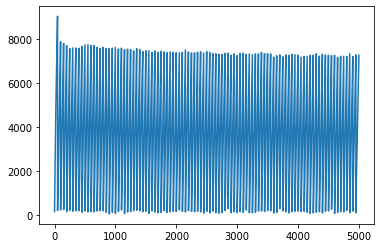

In [271]:
plt.plot(loss_trend)

In [0]:
nlp.pipe_names


['tagger', 'parser', 'entity_ruler', 'ner', 'merge_entities']

In [0]:
ruler = EntityRuler(nlp).from_disk("patterns.jsonl")
nlp.add_pipe(ruler, before='ner')
merge_ents = nlp.create_pipe("merge_entities")
nlp.add_pipe(merge_ents, after='ner')
nlp.pipe_names

['tagger', 'parser', 'entity_ruler', 'ner', 'merge_entities']

In [276]:
test_docs = train_reviews[1500:1510]

for doc in test_docs:
  displacy.render(nlp(doc),'ent',jupyter=True)
  print([(ent.text, ent.label_) for ent in nlp(doc).ents])

[('salad', 'dish'), ('cucumber', 'vegetable'), ('avocado', 'vegetable')]


[('One', 'CARDINAL'), ('chicken', 'dish'), ('cashews', 'dish')]


[('vegan', 'lifestyle'), ('vegan', 'lifestyle'), ('vegetarian', 'lifestyle')]


[('coconut milk', 'dish'), ('vegan', 'lifestyle')]


[('hummus', 'dish'), ('hummus', 'dish'), ('ciabatta', 'dish'), ('one', 'CARDINAL'), ('hummus', 'dish')]


[('vegan', 'lifestyle'), ('vegan', 'lifestyle'), ('vegan', 'lifestyle'), ('vegan', 'lifestyle'), ('breakfast', 'meal'), ('vegan', 'lifestyle'), ('chipotle', 'dish'), ('seitan', 'dish'), ('vegan', 'lifestyle'), ('queso', 'dish')]


[('Malaysian', 'NORP'), ('Nasi', 'dish'), ('rice', 'dish')]


[('noodle', 'dish'), ('Malaysian', 'NORP'), ('mushroom', 'vegetable')]


[('vegan', 'lifestyle'), ('pizza', 'dish'), ('pizza', 'dish'), ('six', 'CARDINAL'), ('vegan', 'lifestyle'), ('pizza', 'dish')]


[('rendang', 'dish')]


In [0]:
pwd

'/gdrive/My Drive/abv_reviews'

In [0]:
check_list

[('bok', 'U_vegetable'),
 ('choy', 'U_vegetable'),
 ('bean', 'U_vegetable'),
 ('sprouts', 'U_vegetable'),
 ('soffritto', 'U_dish'),
 ('patties', 'U_dish'),
 ('cakes', 'U_dish'),
 ('parmesan', 'U_dish'),
 ('cheese', 'U_dish'),
 ('breadcrumbs', 'U_dish'),
 ('soy', 'U_condiment'),
 ('sauce', 'U_condiment'),
 ('olive', 'U_condiment'),
 ('oil', 'U_condiment'),
 ('wine', 'U_beverage'),
 ('3/4-inch', 'U_QUANTITY'),
 ('2-inch', 'U_QUANTITY'),
 ('3-inch', 'U_QUANTITY'),
 ('6-inch', 'U_QUANTITY'),
 ('first', 'U_ORDINAL'),
 ('second', 'U_ORDINAL'),
 ('third', 'U_ORDINAL'),
 ('fourth', 'U_ORDINAL'),
 ('fifth', 'U_ORDINAL'),
 ('last', 'U_ORDINAL'),
 ('1', 'U_CARDINAL'),
 ('2', 'U_CARDINAL'),
 ('3', 'U_CARDINAL'),
 ('4', 'U_CARDINAL'),
 ('5', 'U_CARDINAL'),
 ('6', 'U_CARDINAL'),
 ('10', 'U_CARDINAL'),
 ('100', 'U_CARDINAL'),
 ('one', 'U_CARDINAL'),
 ('two', 'U_CARDINAL'),
 ('three', 'U_CARDINAL'),
 ('four', 'U_CARDINAL'),
 ('five', 'U_CARDINAL'),
 ('six', 'U_CARDINAL'),
 ('seven', 'U_CARDINAL'),
 ('

In [0]:
nlp.to_disk('trained_model_2020_01_08')

In [0]:
import json

with open('checklist.txt', 'w') as f:
    f.write(json.dumps(check_list))

In [0]:
[token.pos_ for token in nlp("lion's mane mushroom falafels")]

['NOUN', 'PART', 'NOUN', 'NOUN', 'NOUN']

In [0]:
for doc in list(nlp.pipe(texts[check])):
  displacy.render(doc,'ent',jupyter=True)
#  displacy.render(doc,'dep',jupyter=True,options={'distance': 60, 'fine_grained': True})